In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed

import sys
import os
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_seqs_2step

In [10]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())
device = 'mps'

True
True


In [11]:
num_classes = 14
batchsize= 5
# specs
input_size = num_classes
output_size = 1
hidden_size = 20
num_layers = 1
learningRate = 0.005


# RNN

In [40]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0].to(device)


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()


def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            x, y = x.to(device), y.to(device)
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            x, y = x.to(device), y.to(device)
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0].to(device)
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

# def run_sim(i):
#     print('########## rep ', i, '##########')
#     model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
#     loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)
#     loss2, acc2 = run_acc(model,optimizer,criterion, trainset[1], test_sets, epochs)
#     losses = loss1+loss2
#     accs = np.vstack([acc1,acc2])
#     return losses, accs

def run_sim(i):
    print('########## rep ', i, '##########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, test_sets, epochs)

    return loss1, acc1, model


def seq_acc(model, testset, hidden_size, rep = 10, verbose = False):
    
    train_inputs = convert_seq2inputs(testset, num_classes=num_classes, seq_len=8)
    testdata = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    model.eval()
    trials = []
    accs = []
    for _ in range(rep):
        for j, (x,y) in enumerate(testdata):
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
                accs.append(float(correct))
                curr_trial = testset[4*j+i].copy()
                trials.append([x for x in curr_trial if x!= ('X', 'X')])
#                 trials.append(curr_trial)
    
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
    df = df.groupby(['trial']).mean().sort_values(by = 'acc', ascending=False)
                
    return df 

# Load Training and Test data

In [41]:
# Load Training and Test data
trianpath = '../sequences/training/'

#Mset
with open(trianpath + 'Mset', 'rb') as f:
    Mset = pickle.load(f)
with open(trianpath + 'Mcombos', 'rb') as f:
    Mcombos = pickle.load(f)
with open(trianpath + 'Morder', 'rb') as f:
    Morder = pickle.load(f)
with open(trianpath + 'Minit', 'rb') as f:
    Minit = pickle.load(f)

# MC set
with open(trianpath + 'MCset', 'rb') as f:
    MCset = pickle.load(f)
with open(trianpath + 'MCorder', 'rb') as f:
    MCorder = pickle.load(f)
with open(trianpath + 'MCinit', 'rb') as f:
    MCinit = pickle.load(f)
    
# DC set
with open(trianpath + 'DCset', 'rb') as f:
    DCset = pickle.load(f)
with open(trianpath + 'DCorder', 'rb') as f:
    DCorder = pickle.load(f)
with open(trianpath + 'DCinit', 'rb') as f:
    DCinit = pickle.load(f)

# F set
with open(trianpath + 'Fset', 'rb') as f:
    Fset = pickle.load(f)
with open(trianpath + 'Finit', 'rb') as f:
    Finit = pickle.load(f)

In [42]:
# convert sequences to inputs 
num_classes = 14

# Mset
train_inputs = convert_seq2inputs(Mset, num_classes=num_classes, seq_len=7)
trainMset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Mcombos, num_classes=num_classes, seq_len=7)
testMcombos = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Morder, num_classes=num_classes, seq_len=7)
testMorder = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Minit, num_classes=num_classes, seq_len=7)
testMinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# MCaset
train_inputs = convert_seq2inputs(MCset, num_classes=num_classes, seq_len=7)
trainMCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCorder, num_classes=num_classes, seq_len=7)
testMCorder = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCinit, num_classes=num_classes, seq_len=7)
testMCinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# DCaset
train_inputs = convert_seq2inputs(DCset, num_classes=num_classes, seq_len=7)
trainDCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCorder, num_classes=num_classes, seq_len=7)
testDCorder = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCinit, num_classes=num_classes, seq_len=7)
testDCinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# Fset
train_inputs = convert_seq2inputs(Fset, num_classes=num_classes, seq_len=7)
trainFset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Finit, num_classes=num_classes, seq_len=7)
testFinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# Train RNN

# Set F

In [50]:
num_sims = 1
epochs = 80
learningRate = 0.001
trainset = trainFset
test_sets = [trainFset, testFinit]

In [51]:
t1 = time.time()
run_sim(1)# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

########## rep  1 ##########
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [43]:
num_sims = 1
epochs = 80
learningRate = 0.001
trainset = trainMCset
test_sets = [trainMCset, testMCinit]
t1 = time.time()
mmres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

mmlosses = np.hstack([mmres[i][0] for i in range(len(mmres))])
accmmtrain = np.array([mmres[i][1][:,0] for i in range(len(mmres))]).T
accmminit = np.array([mmres[i][1][:,1] for i in range(len(mmres))]).T

RuntimeError: writeFileRaw: Device not recognized: mps

In [41]:
epochs = 80

In [47]:
import platform
print(platform.platform())

macOS-10.16-x86_64-i386-64bit


In [26]:
num_sims = 1
epochs = 800
learningRate = 0.001
trainset = trainFset
test_sets = [trainFset, testFinit]
t1 = time.time()
Fres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', t2-t1)

Flosses = np.hstack([Fres[i][0] for i in range(len(Fres))])
accFtrain = np.array([Fres[i][1][:,0] for i in range(len(Fres))]).T
accFinit = np.array([Fres[i][1][:,1] for i in range(len(Fres))]).T

NameError: name 'device' is not defined

In [72]:
print('train final acc:  ', np.mean(accFtrain[-1,:]))
print('init final acc:  ', np.mean(accFinit[-1,:]))

train final acc:   0.1517241379310345
init final acc:   0.12413793103448276


Text(0.5, 1.0, 'F training losses')

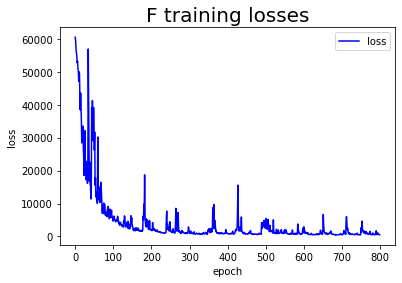

In [73]:
NNplt.plotNN_shifted([Flosses],\
                    labels = ['loss'],\
                    colors = ['blue'],\
                    shift = 0)
plt.title('F training losses', size=20)

In [8]:
NNplt.plotNN_shifted([accFtrain, accFinit],\
                    labels = ['train', 'init'],\
                    colors = ['green', 'red'],\
                    shift = 0)
plt.ylabel('accuracy')
plt.title('F training accuracy', size = 20)
plt.show()

NameError: name 'accFtrain' is not defined